# Imports

In [1]:
import pandas as pd
import re
import joblib

In [2]:
data = pd.read_csv('../../Data/magicbricks_lr.csv')

# Preprocessing

In [3]:
data = data[data['Location_Score'] > 0]

In [4]:
# Columns to drop

def get_column_status():
    """Make a df of all columns and their num nan values, dtype, num unique values"""
    cols = data.columns.tolist()
    col_status = pd.DataFrame(columns=['column', 'num_nan', 'dtype', 'num_unique'])
    for col in cols:
        col_status.loc[len(col_status)] = [col, data[col].isna().sum(), data[col].dtype, data[col].nunique()]
    return col_status

In [5]:
status = get_column_status()
status.sort_values(by='num_nan', ascending=False)

,column,num_nan,dtype,num_unique
13,Unnamed: 13,1179,float64,0
49,Unnamed: 49,1179,float64,0
45,Unnamed: 45,1179,float64,0
47,Unnamed: 47,1179,float64,0
48,Unnamed: 48,1179,float64,0
46,Unnamed: 46,1179,float64,0
35,Car Parking,1177,object,1
34,Possession by,1173,object,4
26,Floors allowed for construction,1146,float64,6
33,RERA ID,1131,object,34


In [6]:
# For rows where Car parking has missing values check if Car Parking has a value and if so, replace the missing value with the value
missing_indices = data[data['Car parking'].isna()].index
for index in missing_indices:
    if not pd.isna(data.loc[index, 'Car Parking']):
        data.loc[index, 'Car parking'] = data.loc[index, 'Car Parking']

In [7]:
cols_to_keep = ['Bedrooms', 'Car parking', 'Furnishing', 'Bathrooms', 'Floor', 'Status', 'Price Breakup', 'Location_Score']
filtered_data = data[cols_to_keep]

In [8]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    def get_price(price: str):
        """
        '₹ 1.72 Cr ₹ 12,03,923 Stamp Duty, Registration Charges ₹ 2,800 Monthly\nSee Other Charges' -> ₹ 1.72 Cr
        '₹ 1.58 Cr ₹ 11,05,986 Stamp Duty, Registration Charges ₹ 2,500 Monthly\nSee Other Charges' -> ₹ 1.58 Cr
        '₹ 1.27 Cr ₹ 8,88,930 Stamp Duty, Registration Charges ₹ 2,850 Monthly\nSee Other Charges' -> ₹ 1.27 Cr
        """
        if type(price) == str:
            num = re.search(r'[.\d]+', price).group()
            suffix = re.search(r'Lac|Cr', price).group()
            if suffix == 'Lac':
                num = float(num)
            elif suffix == 'Cr':
                num = float(num) * 100
            return int(num)


    data = data.copy()
    # Bedrooms
    digits_regex = re.compile(r'[\-\d]+')
    data.loc[:, 'Bedrooms'] = data['Bedrooms'].apply(lambda x: int(digits_regex.search(x).group()) if type(x) == str else x)
    data.loc[:, 'Bedrooms'] = data['Bedrooms'].fillna(data['Bedrooms'].mode()[0])
    data.loc[:, 'Bedrooms'] = data['Bedrooms'].astype(int)

    # Car parking
    # Find all numbers and add
    data.loc[:, 'Car parking'] = data['Car parking'].apply(lambda x: int(sum(map(int, digits_regex.findall(x)))) if type(x) == str and digits_regex.search(x) else x)
    data.loc[:, 'Car parking'] = data['Car parking'].apply(lambda x: x.replace('None', '0') if 'None' in str(x) else x)
    data.loc[:, 'Car parking'] = data['Car parking'].fillna(data['Car parking'].mode()[0])
    data.loc[:, 'Car parking'] = data['Car parking'].astype(int)

    # Furnishing
    data.loc[:, 'Furnishing'] = data['Furnishing'].fillna(data['Furnishing'].mode()[0])
    data.loc[:, 'Furnishing'] = data['Furnishing'].astype('category')

    # Bathrooms
    data.loc[:, 'Bathrooms'] = data['Bathrooms'].fillna(data['Bathrooms'].mode()[0])
    data.loc[:, 'Bathrooms'] = data['Bathrooms'].astype(int)
    
    # Floor
    data.loc[:, 'Floor'] = data['Floor'].apply(lambda x: x.replace('Ground', '0') if type(x) == str else x)
    data.loc[:, 'Floor'] = data['Floor'].apply(lambda x: x.replace('Upper Basement', '-1') if type(x) == str else x)
    data.loc[:, 'Total Floors'] = data['Floor'].apply(lambda x: int(digits_regex.findall(x)[1]) if type(x) == str else x)
    data.loc[:, 'Floor'] = data['Floor'].apply(lambda x: int(digits_regex.findall(x)[0]) if type(x) == str else x)
    data.loc[:, 'Total Floors'] = data['Floor'].fillna(data['Total Floors'].mode()[0])
    data.loc[:, 'Floor'] = data['Floor'].fillna(data['Floor'].mode()[0])
    data.loc[:, 'Total Floors'] = data['Total Floors'].astype(int)
    data.loc[:, 'Floor'] = data['Floor'].astype(int)

    # Location_Score
    data.dropna(subset=['Location_Score'], inplace=True)

    # Status
    data.loc[:, 'Status'] = data['Status'].fillna(data['Status'].mode()[0])
    data.loc[:, 'Status'] = data['Status'].astype('category')

    # Price Breakup
    data.loc[:, 'Price Breakup'] = data['Price Breakup'].apply(get_price)
    data.dropna(subset=['Price Breakup'], inplace=True)


    return data

In [9]:
modified_data = feature_engineering(filtered_data)
modified_data.to_csv('../../Data/magicbricks_lr_modified.csv', index=False)

In [10]:
def encode(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    cat_cols = data.select_dtypes(include=['category']).columns.tolist()
    for col in cat_cols:
        data.loc[:, col] = data[col].cat.codes

    return data

In [11]:
encoded_data = encode(modified_data)
encoded_data.to_csv('../../Data/magicbricks_lr_encoded.csv', index=False)

# Training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
X, y = encoded_data.drop(['Price Breakup'], axis=1), encoded_data['Price Breakup']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

### Scale

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

### Linear Regression

In [70]:
from sklearn.linear_model import LinearRegression

In [80]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [81]:
# Score
print(f'MSE: {mean_squared_error(y_valid, lr.predict(X_valid))}')
print(f'Score: {lr.score(X_valid, y_valid)}')

MSE: 15423.61807221375
Score: 0.4334718671764415


### SVR

In [73]:
from sklearn.svm import SVR

In [74]:
lr = SVR()
lr.fit(X_train, y_train)

SVR()

In [75]:
# Score
print(f'MSE: {mean_squared_error(y_valid, lr.predict(X_valid))}')
print(f'Score: {lr.score(X_valid, y_valid)}')

MSE: 25325.94051756217
Score: 0.06974759578213163


### Random Forest

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
lr = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
lr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

In [100]:
# Score
print(f'MSE: {mean_squared_error(y_valid, lr.predict(X_valid))}')
print(f'Score: {lr.score(X_valid, y_valid)}')

MSE: 18832.458483615836
Score: 0.30826103893087853


### XGBoost

In [16]:
from xgboost import XGBRegressor

In [17]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [19]:
# Score
print(f'MSE: {mean_squared_error(y_valid, xgb.predict(X_valid))}')
print(f'Score: {xgb.score(X_valid, y_valid)}')

MSE: 15682.012488087605
Score: 0.18150450191167788


In [20]:
for y_true, y_predict in zip(y_valid, xgb.predict(X_valid)):
    print(f'{y_true} -> {y_predict}')

170 -> 181.64764404296875
75 -> 116.8585205078125
225 -> 235.030517578125
19 -> 55.46209716796875
159 -> 137.41603088378906
114 -> 31.31996726989746
85 -> 95.91995239257812
148 -> 155.08621215820312
300 -> 456.1022033691406
135 -> 61.7856559753418
310 -> 257.13519287109375
110 -> 74.36990356445312
65 -> 30.043180465698242
250 -> 308.58697509765625
72 -> 54.115177154541016
179 -> 202.3463897705078
168 -> 113.70159912109375
70 -> 91.01724243164062
46 -> 186.65750122070312
67 -> 50.51711654663086
26 -> 141.43017578125
183 -> 194.25160217285156
92 -> 35.344181060791016
65 -> 124.28300476074219
95 -> 244.47096252441406
499 -> 566.2516479492188
120 -> 67.42782592773438
60 -> 50.51711654663086
38 -> 62.13019943237305
185 -> 185.73292541503906
175 -> 128.2425537109375
100 -> 46.419376373291016
60 -> 100.15924072265625
85 -> 85.0031967163086
225 -> 69.18952941894531
40 -> 82.839111328125
225 -> 247.8424835205078
23 -> 105.9490737915039
52 -> 50.51711654663086
140 -> 126.19879150390625
24 -> 94.

In [92]:
# Save Model
joblib.dump(lr, '../../Code/Modelling/Models/lr.model')

['../../Code/Modelling/Models/lr.model']

In [21]:
model = xgb

## Feature Importance

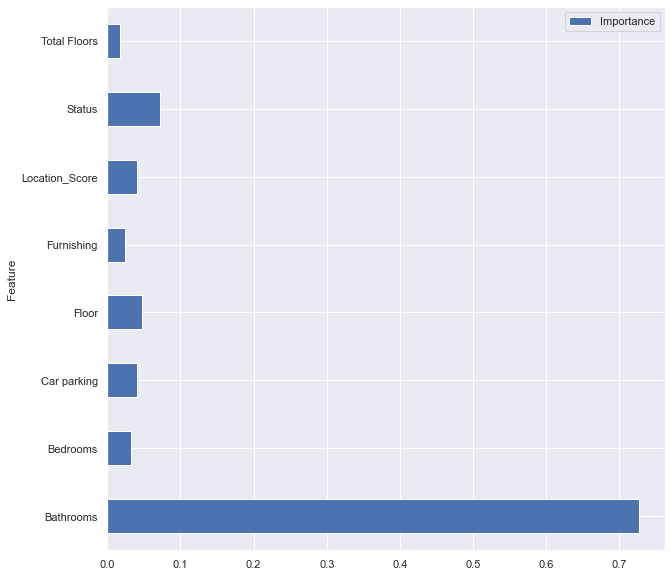

In [25]:
# Graph feature importance
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
imp = pd.DataFrame(sorted(zip(X.columns, model.feature_importances_)), columns=['Feature', 'Importance'])
imp.plot.barh(y='Importance', x='Feature', figsize=(10, 10))
plt.show()